In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import sys
import operator
from scipy import stats
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import requests
from IPython.display import HTML
import matplotlib.pylab as plt
import warnings
import geopandas as gpd
from fiona.crs import from_epsg

import seaborn as sns
sns.set_style('whitegrid')

%pylab inline

/Applications/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


/Applications/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Obesity rates

# Low birth weight + mother's age group data

Retrieved from https://health.data.ny.gov/api/views/94i9-2x7y/rows.csv?accessType=DOWNLOAD 

# Perinatal data

Retrieved from https://www.health.ny.gov/statistics/chac/perinatal/county/2012-2014/

In [29]:
counties = ['niagara', 'erie', 'chautauqua', 'albany', 'allegany', 'broome', 'cattaraugus', 'cayuga', 'chemung',
           'chenango', 'clinton', 'columbia', 'cortland', 'delaware', 'dutchess', 'essex', 'franklin', 'fulton',
           'genesee', 'greene', 'hamilton', 'herkimer', 'jefferson', 'lewis', 'livingston', 'madison', 'monroe',
           'montgomery', 'nassau', 'oneida', 'onondaga', 'ontario', 'orange', 'orleans', 'oswego', 'otsego', 'putnam',
           'queens', 'rensselaer', 'richmond', 'rockland', 'stlawrence', 'saratoga', 'schenectady', 'schoharie',
           'schuyler', 'seneca', 'steuben', 'suffolk', 'sullivan', 'tioga', 'tompkins', 'ulster', 'warren', 
            'washington', 'wayne', 'westchester', 'wyoming', 'yates', 'bronx', 'kings', 'newyork']
tmp = []


for boro in counties:
    html = requests.get('https://www.health.ny.gov/statistics/chac/perinatal/county/2012-2014/' + 
                       boro + '.htm').content
    foo = pd.read_html(html)[0]
    foo = foo.iloc[2:]
    tmp.append(foo)
    
birth = pd.concat(tmp, axis = 0)
birth = birth.iloc[:,:4]
birth.columns = ['ZipCode', 'TotalBirths2012-2014', 'PrematureBirth', 'LowBirthWeight']
birth.reset_index(inplace = True)
birth = birth.drop('index', axis=1)

In [30]:
print(birth.shape)
birth.head()

(1516, 4)


,ZipCode,TotalBirths2012-2014,PrematureBirth,LowBirthWeight
0,14008,34,2.9,0.0
1,14012,67,10.4,6.0
2,14028,47,8.5,10.6
3,14067,120,5.8,6.7
4,14092,219,8.7,5.5


In [31]:
birth.dtypes

ZipCode                 object
TotalBirths2012-2014    object
PrematureBirth          object
LowBirthWeight          object
dtype: object

In [32]:
birth1 = pd.concat(tmp, axis = 0)
birth1 = birth1.iloc[:,-2:-1]
birth1.columns = ['TeenBirthRate']
birth1.reset_index(inplace = True)
birth1 = birth1.drop('index', axis=1)

In [33]:
birth = birth1.merge(birth, left_index=True, right_index=True)
birth
birth.head()

,TeenBirthRate,ZipCode,TotalBirths2012-2014,PrematureBirth,LowBirthWeight
0,5.6,14008,34,2.9,0.0
1,13.6,14012,67,10.4,6.0
2,5.1,14028,47,8.5,10.6
3,11.7,14067,120,5.8,6.7
4,3.8,14092,219,8.7,5.5


In [34]:
#birth['ZipCode'] = birth['ZipCode'].astype('int')
birth['TotalBirths2012-2014'] = birth['TotalBirths2012-2014'].astype('float')
birth['PrematureBirth'] = birth['PrematureBirth'].astype('float')
birth['LowBirthWeight'] = birth['LowBirthWeight'].astype('float')
birth['TeenBirthRate'] = birth['TeenBirthRate'].apply(pd.to_numeric, errors='coerce').dropna()
# birth['TeenBirthRate'] = birth['TeenBirthRate'].astype('float')

In [35]:
birth.dtypes

TeenBirthRate           float64
ZipCode                  object
TotalBirths2012-2014    float64
PrematureBirth          float64
LowBirthWeight          float64
dtype: object

In [36]:
birth.head()

,TeenBirthRate,ZipCode,TotalBirths2012-2014,PrematureBirth,LowBirthWeight
0,5.6,14008,34.0,2.9,0.0
1,13.6,14012,67.0,10.4,6.0
2,5.1,14028,47.0,8.5,10.6
3,11.7,14067,120.0,5.8,6.7
4,3.8,14092,219.0,8.7,5.5


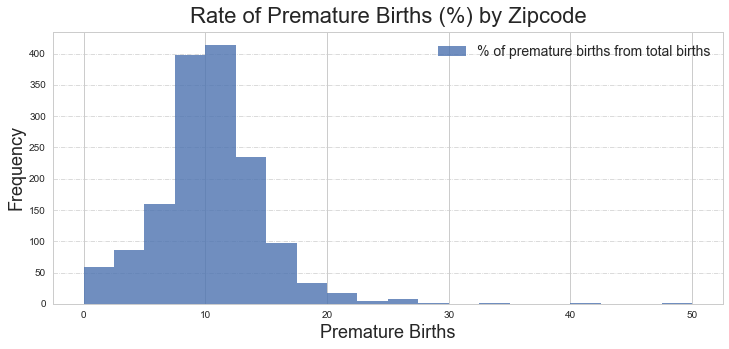

In [37]:
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(111)

birth['PrematureBirth'].plot(kind="hist", bins=20, label='% of premature births from total births', alpha=0.8)

ax.set_title("Rate of Premature Births (%) by Zipcode", fontsize=22, y=1.01)
ax.set_xlabel("Premature Births", fontsize=18)
ax.set_ylabel("Frequency", fontsize=18)


plt.grid(linewidth=0.7, axis='y', linestyle='-.')
plt.legend(fontsize=14)
plt.show()

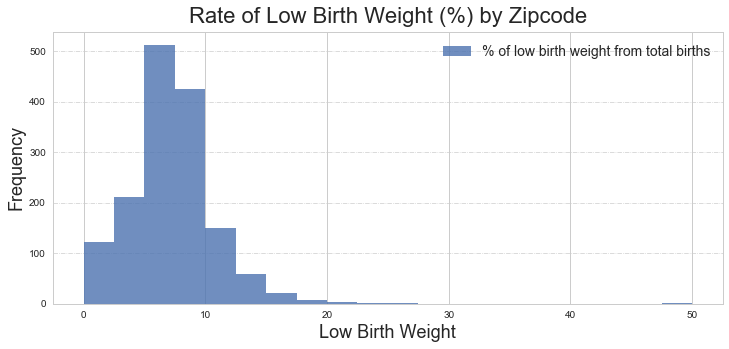

In [38]:
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(111)

birth['LowBirthWeight'].plot(kind="hist", bins=20, label='% of low birth weight from total births', alpha=0.8)

ax.set_title("Rate of Low Birth Weight (%) by Zipcode", fontsize=22, y=1.01)
ax.set_xlabel("Low Birth Weight", fontsize=18)
ax.set_ylabel("Frequency", fontsize=18)


plt.grid(linewidth=0.7, axis='y', linestyle='-.')
plt.legend(fontsize=14)
plt.show()

In [39]:
len(birth.ZipCode.unique())

1455

In [40]:
birth = birth.drop_duplicates(subset=['ZipCode'])
print(birth.shape)

(1455, 5)


In [41]:
birth.to_csv('birthNYS.csv')

----
# Combine food desert data with birth data

-----